# Is it possible to predict lightning strikes using machine learning?

The data in this set was collected using NOAA's Geostationary Lightning Mapper, along with GOES-R Data. 
A reference to collecting GLM Data can be found here: https://docs.opendata.aws/noaa-goes16/cics-readme.html

Lightning is a rare event on a geospatial scale. Although millions of lightning strikes occur each day, the large scale of the CONUS alone limits the number of strikes you can confidently place on the map. This makes our dataset relatively imbalanced. 

In the following notebook we discuss methods to implement machine learning algorithms on an imbalanced dataset. 



In [146]:
#pandas and numpy

import pandas as pd
import numpy as np

# Modelling
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

#Load the csv into python
df = pd.read_csv("/Users/robbiefeldstein/Documents/Programming/Research/Datasets/2022-07-12.csv")
df.head()

,Unnamed: 0,Coordinates,nearest_time,lightning,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,...,CMI_C15,CMI_C16,ACM,BCM,Cloud_Probabilities,lat,lon,time,time_int,Lightning
0,0,"(48.993860516070626, -83.7736658374815)",0,0.0,0.236587,0.174186,0.278670,0.050417,0.125972,0.119603,...,255.69264,246.76305,3.0,1.0,0.999409,48.993861,-83.773666,2022-07-12 21:00:31.526922880,1657659631526922880,0
1,1,"(48.99119011711506, -83.65414571275491)",0,0.0,0.278194,0.216924,0.316170,0.071548,0.147758,0.148095,...,250.79752,243.57520,3.0,1.0,0.999407,48.991190,-83.654146,2022-07-12 21:00:31.526922880,1657659631526922880,0
2,2,"(48.98855756013775, -83.5346982880049)",0,0.0,0.274206,0.214127,0.311289,0.075555,0.150476,0.147222,...,251.06924,243.58554,3.0,1.0,0.999408,48.988558,-83.534698,2022-07-12 21:00:31.526922880,1657659631526922880,0
3,3,"(48.985962770730005, -83.41532245956029)",0,0.0,0.200595,0.138790,0.219166,0.046409,0.107877,0.096905,...,261.23926,250.17465,3.0,1.0,0.999421,48.985963,-83.415322,2022-07-12 21:00:31.526922880,1657659631526922880,0
4,4,"(48.983405675701626, -83.29601712874923)",0,0.0,0.187619,0.125615,0.238928,0.030317,0.112639,0.089048,...,267.89890,254.82904,3.0,1.0,0.999548,48.983406,-83.296017,2022-07-12 21:00:31.526922880,1657659631526922880,0


## Exploratory Data Analysis

Let's begin by investigating the imbalance of the dataset! We make a simple pie chart to help visualize the problem.

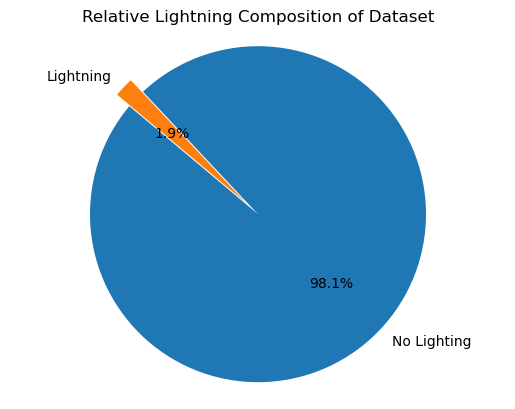

In [147]:
#Percentage of Strikes
strikes = 100*len(df[df["Lightning"]==1])/len(df)
#Percentage of non-strikes
non_strikes = 100*len(df[df["Lightning"]==0])/len(df)

#Label List
labels = ['No Lighting', 'Lightning']
sizes = [non_strikes,strikes]  # Percentages

# Explode the second slice (Lightning)
explode = (0, 0.1)

# Create the pie chart
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=140)

plt.title("Relative Lightning Composition of Dataset")
# Set the aspect ratio to be equal, so the pie is a circle.
plt.axis('equal')

# Display the pie chart
plt.show()


### Correlations and Collinearity

Now that we understand the class imbalance, we should make a simple correlation heatmap to try to find collinearity in our predictors. 

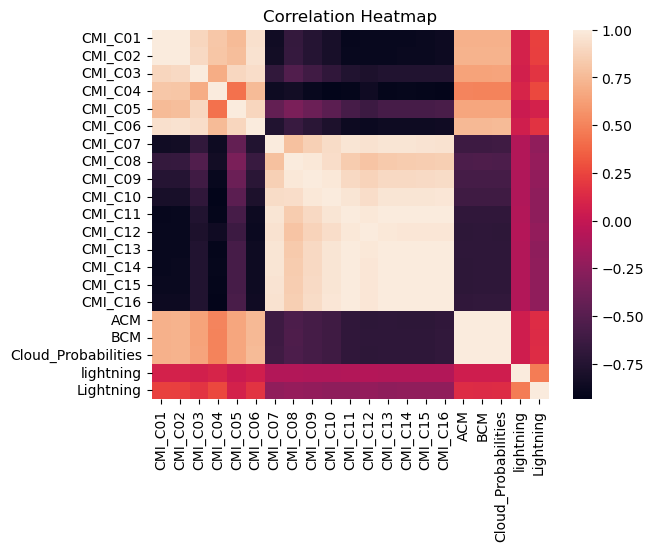

In [148]:
numeric = df[["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities","lightning", "Lightning"]]
#numeric = df[["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities","Bubbling", "Cloud_Probability Change", "Interaction Effect","lightning", "Lightning"]]

sns.heatmap(numeric.corr())
plt.title("Correlation Heatmap")
plt.show()

### Boxplot

We see some major correlations in our variables. We also notice that none of the predictors seem to be highly correlated with Lightning. This collinearity in predictors makes sense; the weather data taken by the satellite often measures related variables. 

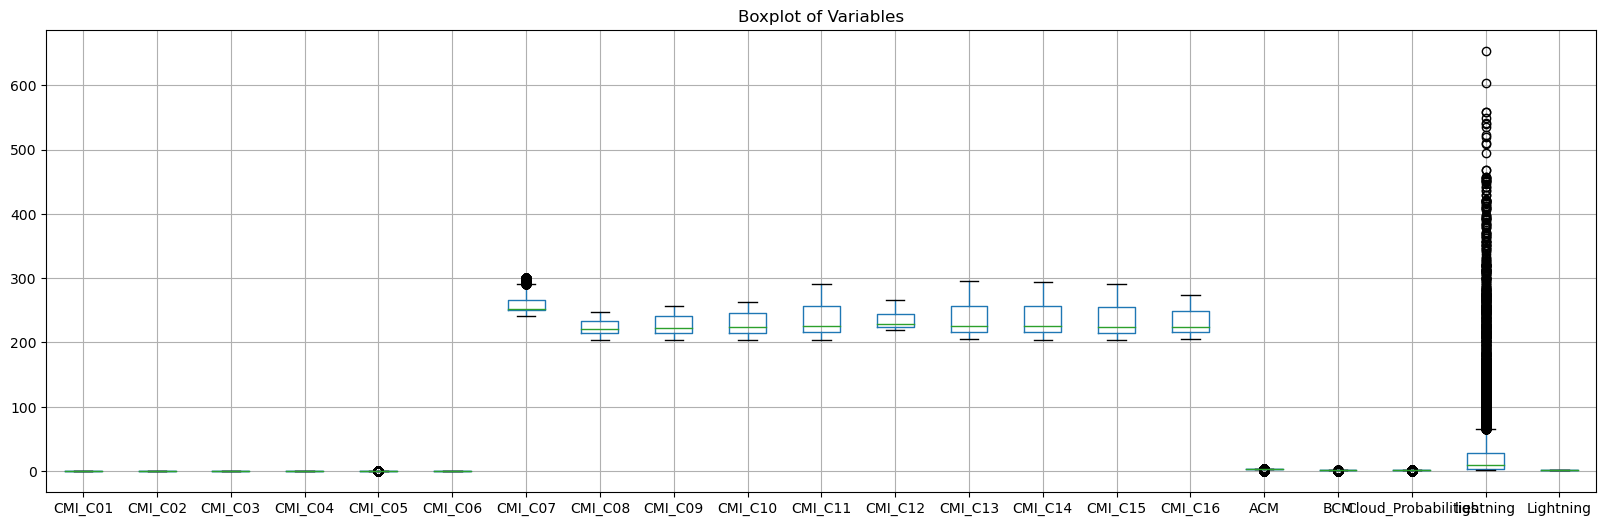

In [149]:
# numeric_nolightning = numeric[numeric["Lightning"]==0]
fig, ax = plt.subplots(figsize=(20, 6))
# numeric_nolightning.boxplot()
numeric_lightning = numeric[numeric["Lightning"]==1]
numeric_lightning.boxplot()
plt.title("Boxplot of Variables")
plt.show()

It looks like there are significantly more outliers in the lightning set. In particular, it looks like higher values of CMI_07-CMI_16 might be good indicators of a lightning strike. Given their extremely high correlations, we probably only need one or two of them to include in the model; otherwise we are just adding collinearity.   

## Train Test Split & Data Preprocessing

In [150]:
#Pick three "important predictors"; this is relatively up to interpretation. Cloud_Probabilities was chosen, as lightning needs clouds! (mostly)

#predictors = ["CMI_C01","CMI_C02","CMI_C03","CMI_C04","CMI_C05","CMI_C06","CMI_C07","CMI_C08","CMI_C09","CMI_C10","CMI_C11","CMI_C12","CMI_C13","CMI_C14","CMI_C15", "CMI_C16" ,"ACM","BCM","Cloud_Probabilities"]
predictors = ["CMI_C01","CMI_C07","Cloud_Probabilities"]
#X is our prediction matrix, y i a series of response data. 
X = df[predictors].copy()
y = df[["Lightning"]].copy()

#Normalize X before training classification models
X = (X-X.mean())/X.std()

#30% Training, 70% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)


## Logistic Regression

We start with a binary logistic regression classifier. While logistic regression does not typically perform the best in place of more flexible algorithms, it is easily interpretable!

Note: We specify class_weight = "balanced" to ensure that the logistic regression does not classify 0 lighting. A naive model would just be to classify no lightning anywhere, and it would perform quite well! 

In [151]:
#Logistic Regression

#BALANCED Logistic Regression!
model = LogisticRegression(max_iter = 10000,random_state=2)

model.fit(X_train, y_train["Lightning"])
y_pred = model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

#Calculate precision
log_precision = precision_score(y_test, y_pred)



Confusion Matrix:
[[275864      0]
 [  5386      0]]


/Users/robbiefeldstein/anaconda3/envs/GOES/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robbiefeldstein/anaconda3/envs/GOES/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    275864
           1       0.00      0.00      0.00      5386

    accuracy                           0.98    281250
   macro avg       0.49      0.50      0.50    281250
weighted avg       0.96      0.98      0.97    281250



/Users/robbiefeldstein/anaconda3/envs/GOES/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robbiefeldstein/anaconda3/envs/GOES/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interpretation of Logistic Regression Classifier

Looking at the above confusion matrix and classification report, we see a poorly performing model. In particular, look at its Type-1 Error Rate. The model predicts 49746 additional lightning strikes than actually occurred! Despite all of these false positives, it did not manage to correctly classify all the lightning, and missed 12 strikes! Still a 93% recall rate is desirable, although the f1-score and precision are abysmally low. 

We could spend time to tune the above logistic regression model, but we are better suited using more advanced machine learning methods than logistic regression.

## Random Forests

Rather than using logistic regression and sigmoid functions to classify our data, let's try utilizing decision trees. The RandomForest algorithm is an ensemble of decision trees. In particular, it bootstraps our dataset into several datasets and forms a decision tree for each bootstrap. These decision trees are aggregated to form a "forest" where one final decision tree is used to classify the model.

In [152]:
# Create a Random Forest model
#Again, specify balanced class weights!
model = RandomForestClassifier(n_estimators=10, random_state=2)  # For regression, use RandomForestRegressor

# Fit the model on the training data
model.fit(X_train, y_train["Lightning"])

# Make predictions on the test data
y_pred = model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

scores = cross_val_score(model, X_test, y_pred, cv=5, scoring='f1')
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

#Calculate precision
rf_precision = precision_score(y_test, y_pred)

Confusion Matrix:
[[275170    694]
 [  4661    725]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    275864
           1       0.51      0.13      0.21      5386

    accuracy                           0.98    281250
   macro avg       0.75      0.57      0.60    281250
weighted avg       0.97      0.98      0.98    281250

Cross-validation scores: [0.42239186 0.4516129  0.43734644 0.45365854 0.48076923]
Mean cross-validation score: 0.4491557930866404


### Random Forest Interpretation

This is a significantly improved model. While the recall rate has dropped dramatically to just 25%, the type one error rate has dropped to just 35 false positives. The precision and f1-scores have jumped significantly. Again, the random forest model could have its hyperparameters tuned, but we will move on to more advanced algorithms!

## XGboost Regressor

We now move on to using XGBoost (Extreme Gradient Boosting). XGBoost is also based on using decision trees. Similar to the random forest technique seen above, it is an ensemble algorithm. XGBoost sequentially adds decision trees to the forest, while seeking to minimize the mean squared training error. After fitting trees, it backpedals to reduce model complexity, prevent overfitting, and lower the variance of the model. It is an incredibly powerful, and fast training algorithm. 

In [162]:
#Generate the ratio of lightning to non_lighting 
lightning_count = sum(y["Lightning"])
non_lightning = len(y) - lightning_count
ratio = non_lightning/lightning_count

xgb_model = xgb.XGBClassifier(scale_pos_weight=ratio)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [163]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

#Calculate precision
xgb_precision = precision_score(y_test, y_pred)

Accuracy: 0.86
Confusion Matrix:
[[236141  39723]
 [   816   4570]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    275864
           1       0.10      0.85      0.18      5386

    accuracy                           0.86    281250
   macro avg       0.55      0.85      0.55    281250
weighted avg       0.98      0.86      0.91    281250



### Interpretation of XGBoost Regressor

These are the best results seen so far! The recall rate and precision scores are relatively high, and the F-score has jumped to almost 50%. The false positive rate is slightly high, with 144 false lightning strikes predicted. 

## Naive Bayes

In [155]:
from sklearn.naive_bayes import GaussianNB


nb_classifier = GaussianNB()  # Adjust class prior probabilities
#nb_classifier.class_prior_ = [0.001, 0.999]
nb_classifier.fit(X_train, y_train["Lightning"])

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

#Calculate precision
nb_precision = precision_score(y_test, y_pred)

Accuracy: 0.88
Confusion Matrix:
[[244853  31011]
 [  1689   3697]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    275864
           1       0.11      0.69      0.18      5386

    accuracy                           0.88    281250
   macro avg       0.55      0.79      0.56    281250
weighted avg       0.98      0.88      0.92    281250



## QDA

In [156]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(priors=[0.1,0.9])
qda.fit(X_train, y_train["Lightning"])

y_pred = qda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

#Calculate precision
qda_precision = precision_score(y_test, y_pred)


Accuracy: 0.53
Confusion Matrix:
[[143674 132190]
 [   253   5133]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    275864
           1       0.04      0.95      0.07      5386

    accuracy                           0.53    281250
   macro avg       0.52      0.74      0.38    281250
weighted avg       0.98      0.53      0.67    281250



## Light Gradient Boosting

In [157]:
import lightgbm as lgb 
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 128,
    'learning_rate': 0.01,
    'feature_fraction': non_lightning/len(df),
    'force_row_wise':True
}


num_round = 512 # Number of boosting rounds
bst = lgb.train(params, train_data, num_round)

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

threshold = 0.25



accuracy = accuracy_score(y_test, (y_pred > threshold).astype(int))
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, (y_pred > threshold).astype(int))
print('Confusion Matrix:')
print(confusion)



classification_rep = classification_report(y_test, (y_pred > threshold).astype(int))
print('Classification Report:')
print(classification_rep)

#Calculate precision
lgb_precision = precision_score(y_test, (y_pred > threshold).astype(int))

[LightGBM] [Info] Number of positive: 12345, number of negative: 643905
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 656250, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018811 -> initscore=-3.954300
[LightGBM] [Info] Start training from score -3.954300
Accuracy: 0.98
Confusion Matrix:
[[274358   1506]
 [  4127   1259]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    275864
           1       0.46      0.23      0.31      5386

    accuracy                           0.98    281250
   macro avg       0.72      0.61      0.65    281250
weighted avg       0.98      0.98      0.98    281250



## Convolutional Neural Networks

## Model Comparisons

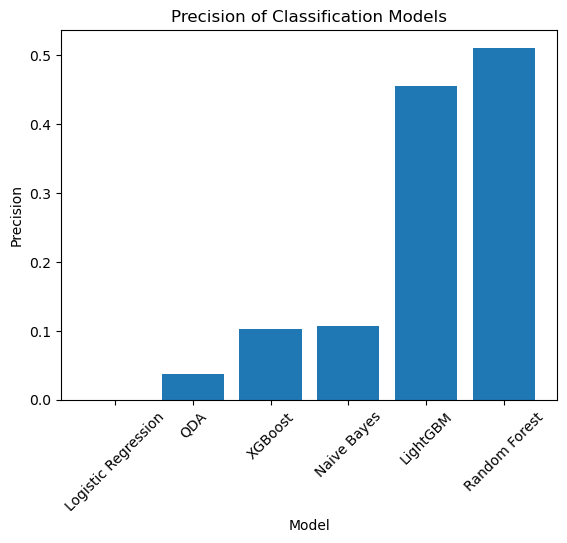

In [158]:
# Make a bar graph of all of the precision scores
#Sort the graph by precision score from lowest to highest

#Create a list of all of the precision scores
precision_list = [log_precision, rf_precision, xgb_precision, nb_precision, qda_precision, lgb_precision]

#Create a list of all of the models
model_list = ["Logistic Regression", "Random Forest", "XGBoost", "Naive Bayes", "QDA", "LightGBM"]

#Create a dictionary of the model and precision score
model_precision_dict = dict(zip(model_list, precision_list))

#Sort the dictionary by precision score
sorted_model_precision_dict = dict(sorted(model_precision_dict.items(), key=lambda item: item[1]))

#Create a list of the sorted precision scores
sorted_precision_list = list(sorted_model_precision_dict.values())

#Create a list of the sorted models
sorted_model_list = list(sorted_model_precision_dict.keys())

#Plot the bar graph
plt.bar(sorted_model_list, sorted_precision_list)
plt.title("Precision of Classification Models")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.show()


## *Best* Model

In [164]:
#Apply the light gradient boosting model to the entire dataset
df["Predicted"] = xgb_model.predict(X)
df["Predicted"] = df["Predicted"].astype(int)
df["The Same"] = df["Predicted"] == df["Lightning"]
df["The Same"] = df["The Same"].astype(int)
df

,Unnamed: 0,Coordinates,nearest_time,lightning,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,...,ACM,BCM,Cloud_Probabilities,lat,lon,time,time_int,Lightning,Predicted,The Same
0,0,"(48.993860516070626, -83.7736658374815)",0,0.0,0.236587,0.174186,0.278670,0.050417,0.125972,0.119603,...,3.000000,1.000000,0.999409,48.993861,-83.773666,2022-07-12 21:00:31.526922880,1657659631526922880,0,0,1
1,1,"(48.99119011711506, -83.65414571275491)",0,0.0,0.278194,0.216924,0.316170,0.071548,0.147758,0.148095,...,3.000000,1.000000,0.999407,48.991190,-83.654146,2022-07-12 21:00:31.526922880,1657659631526922880,0,0,1
2,2,"(48.98855756013775, -83.5346982880049)",0,0.0,0.274206,0.214127,0.311289,0.075555,0.150476,0.147222,...,3.000000,1.000000,0.999408,48.988558,-83.534698,2022-07-12 21:00:31.526922880,1657659631526922880,0,0,1
3,3,"(48.985962770730005, -83.41532245956029)",0,0.0,0.200595,0.138790,0.219166,0.046409,0.107877,0.096905,...,3.000000,1.000000,0.999421,48.985963,-83.415322,2022-07-12 21:00:31.526922880,1657659631526922880,0,0,1
4,4,"(48.983405675701626, -83.29601712874923)",0,0.0,0.187619,0.125615,0.238928,0.030317,0.112639,0.089048,...,3.000000,1.000000,0.999548,48.983406,-83.296017,2022-07-12 21:00:31.526922880,1657659631526922880,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937495,937495,"(34.73943928101468, -70.86642464769157)",0,0.0,0.078055,0.033651,0.028254,0.000397,0.023591,0.017778,...,1.186333,0.515621,0.487633,34.739439,-70.866425,2022-07-12 21:59:28.358647040,1657663168358647040,0,0,1
937496,937496,"(34.74013953611376, -70.77529665745446)",0,0.0,0.109762,0.071091,0.076667,0.000437,0.067540,0.048492,...,2.234376,0.781248,0.764120,34.740140,-70.775297,2022-07-12 21:59:28.358647040,1657663168358647040,0,0,1
937497,937497,"(34.74085517355022, -70.68415030183958)",0,0.0,0.065774,0.019881,0.010734,0.000437,0.005139,0.003810,...,0.140627,0.062501,0.037118,34.740855,-70.684150,2022-07-12 21:59:28.358647040,1657663168358647040,0,0,1
937498,937498,"(34.74158620369715, -70.59298517586424)",0,0.0,0.062917,0.017202,0.007143,0.000476,0.001369,0.000794,...,0.000000,0.000000,0.001231,34.741586,-70.592985,2022-07-12 21:59:28.358647040,1657663168358647040,0,0,1


In [165]:
predicted_lats = df[df["Predicted"]==1]["lat"]
predicted_lons = df[df["Predicted"]==1]["lon"]

actual_lats = df[df["Lightning"]==1]["lat"]
actual_lons = df[df["Lightning"]==1]["lon"]

#Lats where the prediction was 1 and the actual was 1
correct_lats = df[(df["Predicted"]==1) & (df["Lightning"]==1)]['lat']
correct_lons = df[(df["Predicted"]==1) & (df["Lightning"]==1)]['lon']




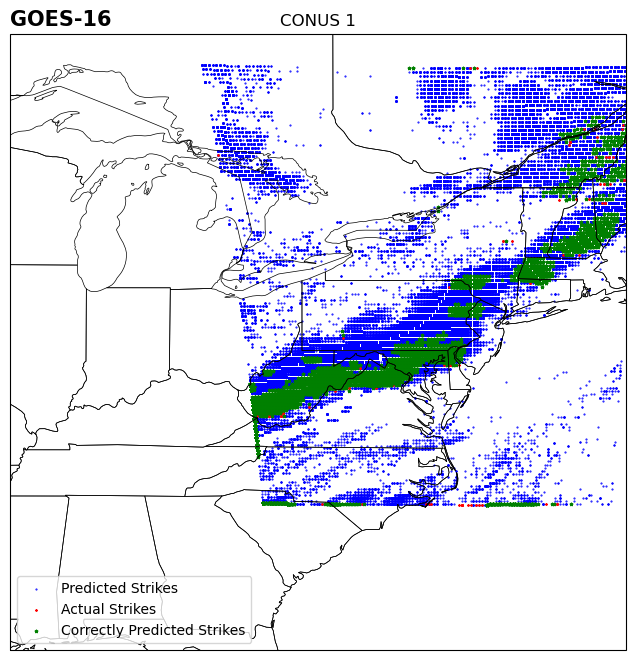

In [168]:
#Make a mpa of the predicted strikes and the actual strikes 

import cartopy.crs as ccrs
from datetime import datetime
    
# lc = ccrs.LambertConformal(central_longitude=-97.5,
#                             standard_parallels=(38.5, 38.5))

fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -70, 30, 50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)

#Plot the GLM Data
ax.scatter(predicted_lons[:], predicted_lats[:],  marker = ".",color = 'blue',s=1)
ax.scatter(actual_lons[:], actual_lats[:],  marker = "*",color = 'red',s=1)
ax.scatter(correct_lons[:], correct_lats[:],  marker = "*",color = 'green',s=4)

#Add legend
ax.legend(['Predicted Strikes', 'Actual Strikes', 'Correctly Predicted Strikes'])


plt.title('GOES-16', fontweight='bold', fontsize=15, loc='left')
plt.title('CONUS 1')
plt.show()
